In [1]:
source('../NMEG_utils/r_functions/load_nmeg.r')
source('~/current/NMEG_utils/r_functions/printfigs.r')
library('xts')
library('forecast')
library('tseries')
library('astsa')
library('ggplot2')

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 6.2 


Attaching package: ‘astsa’

The following object is masked from ‘package:forecast’:

    gas



In [95]:
# Get data and convert some variables to weekly frequency
site <- 'Mpj'
flux <- daily_to_xts(get_daily_file(site, 'aflx', make_new=FALSE))

# If data needs to be removed...
sum(is.na(flux$P_F_sum))
#flux <- flux[366:nrow(flux)]
head(flux)

# convert to weekly values
p <- apply.weekly(flux$P_F_sum, sum)
ta <- apply.weekly(flux$TA_F_avg, mean)
nee <- apply.weekly(flux$FC_F_g_int, sum)
gpp <- apply.weekly(flux$GPP_g_int, sum)
re <- apply.weekly(flux$RECO_g_int, sum)

[1] 0

           GPP_g_int RECO_g_int  FC_F_g_int ET_mm_24hint_0 P_F_sum   TA_F_avg
2008-01-01 0.7801624  0.7630259 -0.01713650      0.3889145 0.00000 -6.8149389
2008-01-02 0.8874377  0.8523381 -0.03509953      0.3283609 0.00000 -3.7352119
2008-01-03 0.7399660  0.7671620  0.02719598      0.2930920 0.00000 -0.2215304
2008-01-04 0.4765313  0.5140788  0.03754754      0.1464250 0.00000  2.8862279
2008-01-05 0.2937063  0.5957370  0.30203077      0.2076932 0.00000  5.2494256
2008-01-06 0.6186638  0.5697245 -0.04893923      0.2676718 0.90069  3.6905300
           RH_F_avg SW_IN_F_avg RNET_F_avg VPD_F_avg  TA_F_min VPD_F_min
2008-01-01 23.07702   164.87589         NA 0.2950942 -12.19151  0.161228
2008-01-02 38.74522   100.85973         NA 0.2926247  -6.98115  0.195523
2008-01-03 38.35478   139.49342         NA 0.3891233  -5.25620  0.228244
2008-01-04 57.74541   139.01638         NA 0.3222331  -0.16010  0.142429
2008-01-05 63.67989    80.18286         NA 0.3345487   1.62348  0.116569
2008-01-06 76.18

## Test models for simulating GPP

### Smoothing models

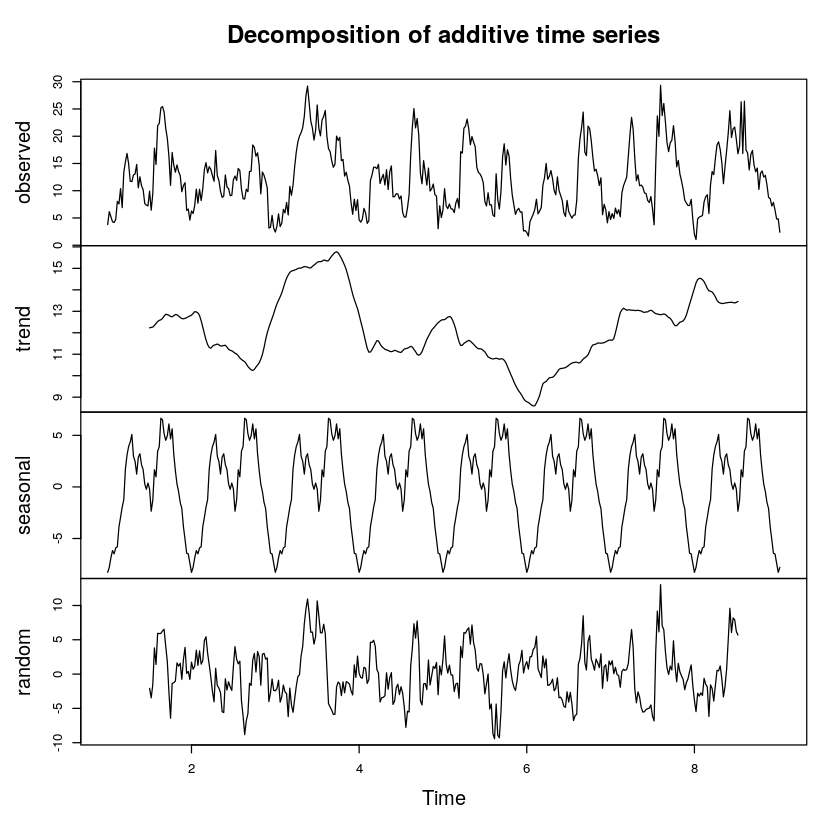

In [96]:
# Create a timeseries object and decompose it
#gpp_ts<-ts(gpp, frequency = 52, start = c(2008, 1, 6),end = c(2014, 12, 31))
attr(gpp, 'frequency') <- 52
gpp_decomp <- decompose(as.ts(gpp))

# Plot
decomp_plot1 <- plot(gpp_decomp)

# Add seasonal and seasonal + trend columns to gpp
gpp$decomp_seas <- xts(gpp_decomp$seasonal + mean(gpp, na.rm=TRUE), index(gpp))
gpp$decomp_seastrend <- xts(gpp_decomp$seasonal + gpp_decomp$trend, index(gpp))
#head(gpp)

pdf 
  2

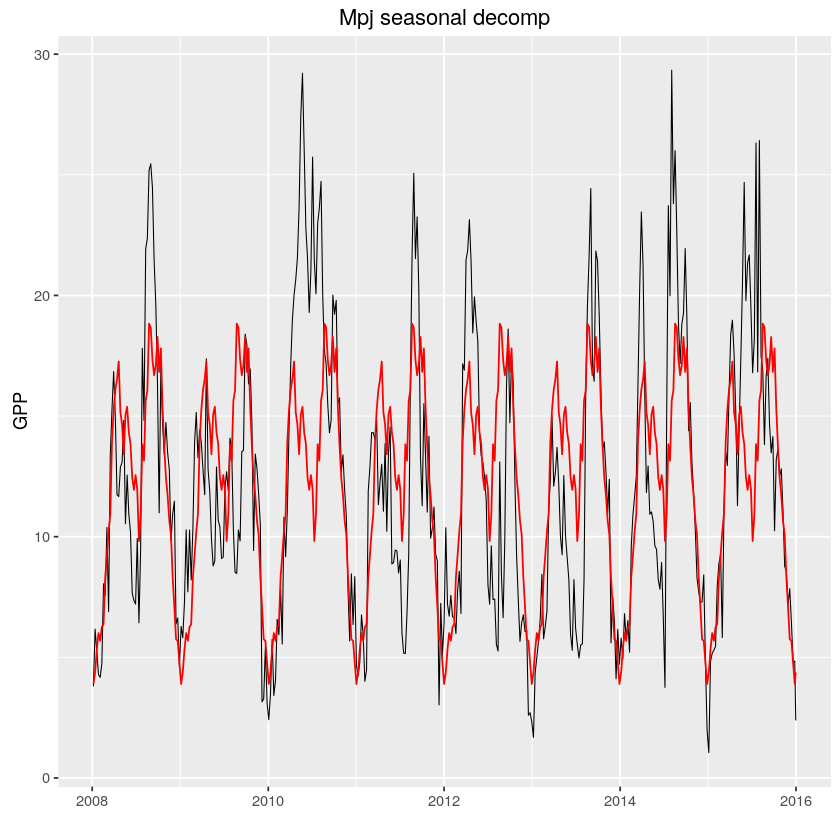

In [97]:
# Plot the seasonal mean
decomp_plot2 <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), decomp_seas), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'seasonal decomp', sep=' '))
decomp_plot2
printfigs(decomp_plot2, paste(site, '_decomp_seas.svg', sep=''), 'figures/', 6, 2.5)

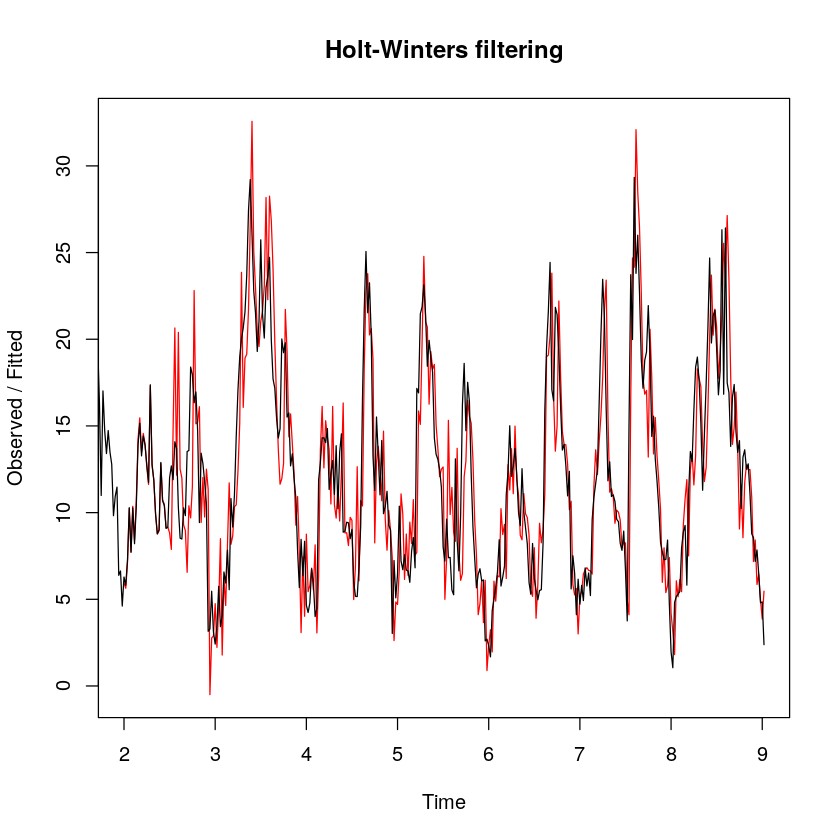

In [22]:
# Then Holt-Winters exponential smoothing
gpp_HW <- HoltWinters(gpp$GPP_g_int)
plot(gpp_HW)

### Linear model with temp

pdf 
  2

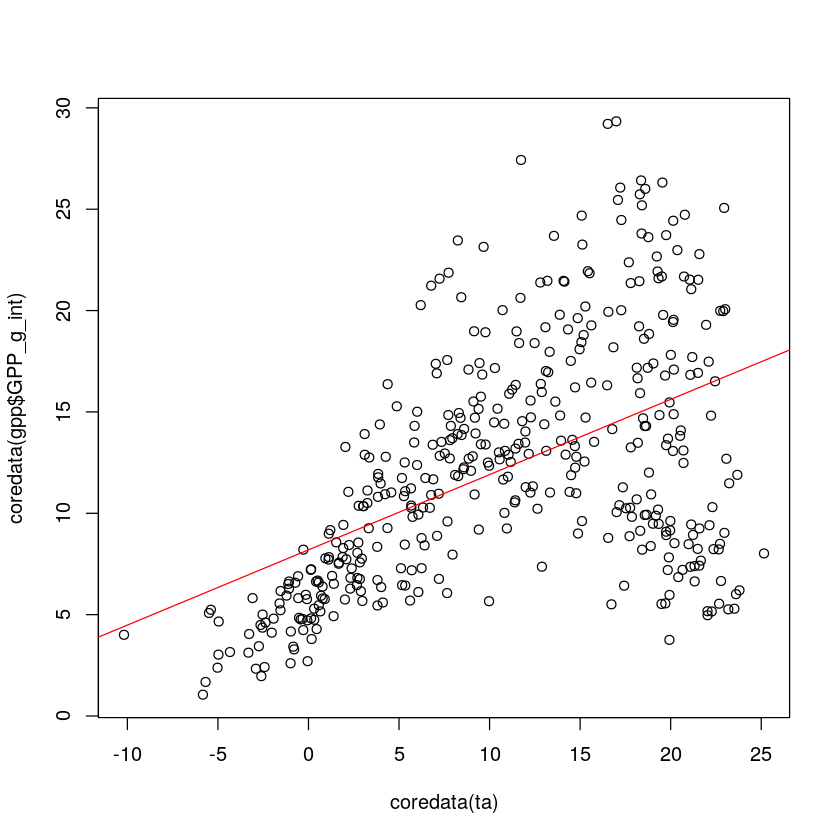

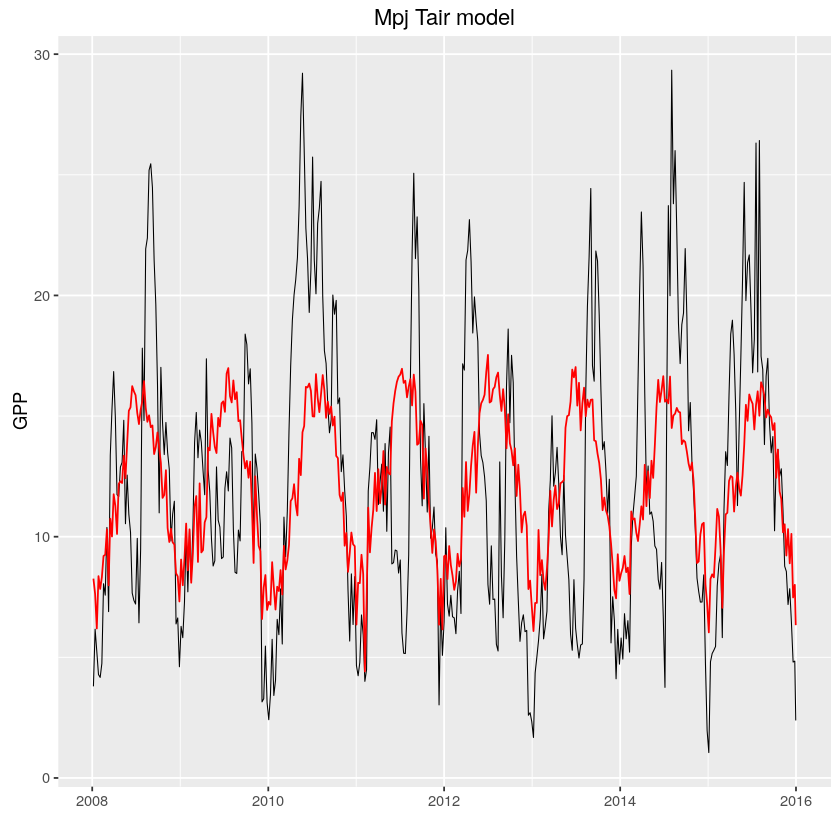

In [98]:
# First make a scatterplot
plot(coredata(ta), coredata(gpp$GPP_g_int))
# Fit model
fit_ta_lm <- lm(coredata(gpp$GPP_g_int) ~ coredata(ta))
gpp$fitted_ta_lm <- xts(fitted(fit_ta_lm), index(gpp))
abline(fit_ta_lm, col='red')

ta_plot <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), fitted_ta_lm), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'Tair model', sep=' '))
printfigs(ta_plot, paste(site, '_ta_linmod.svg', sep=''), 'figures/', 6, 2.5)
ta_plot

### Linear model temp + precip

In [117]:
# rolling sum of precip?
p_3wk <- rollapply(p, 3, sum, fill=NA, align='right')
head(p_3wk)

            P_F_sum
2008-01-06       NA
2008-01-13       NA
2008-01-20 15.01142
2008-01-27 14.81126
2008-02-03  2.50190
2008-02-10  6.90525

Warning message:
: Removed 2 rows containing missing values (geom_path).

pdf 
  2

Warning message:
: Removed 2 rows containing missing values (geom_path).

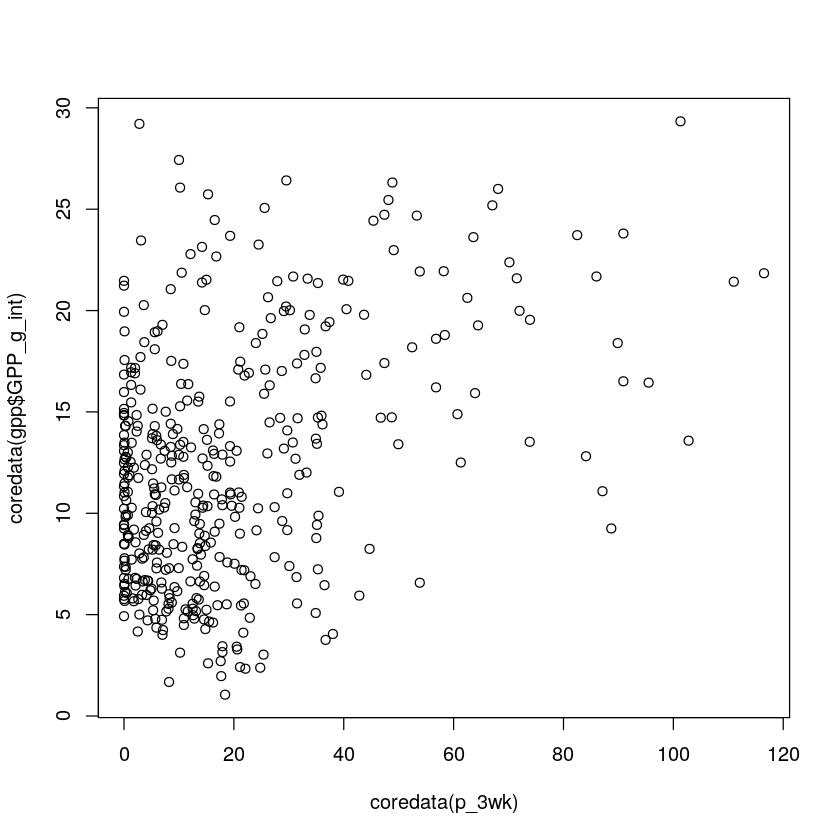

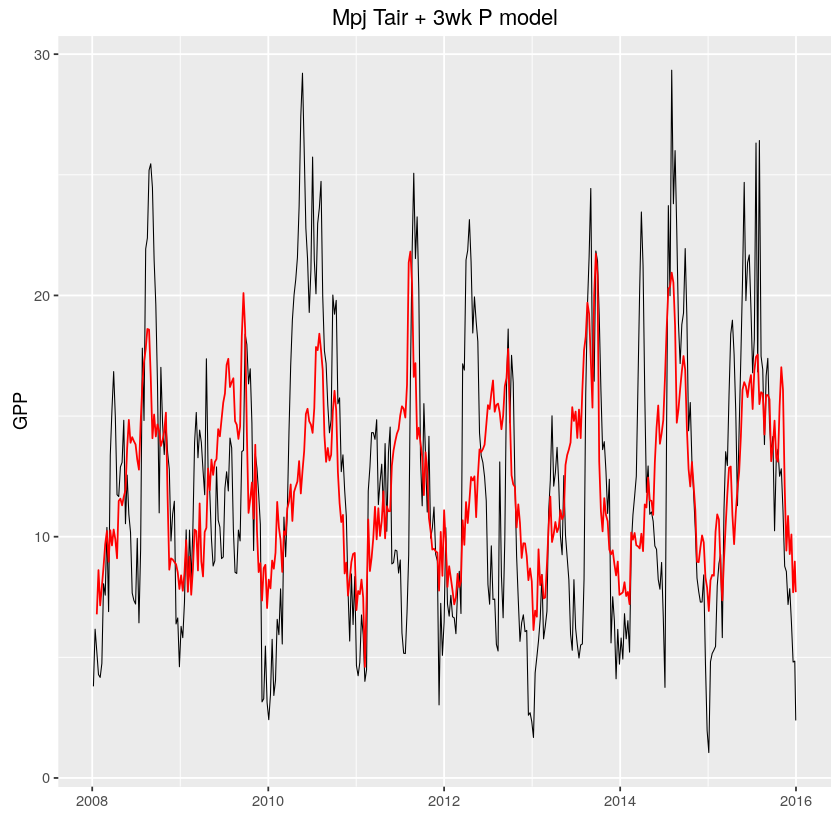

In [118]:
# First make a scatterplot
plot(coredata(p_3wk), coredata(gpp$GPP_g_int))
# Fit model
fit_taP_lm <- lm(coredata(gpp$GPP_g_int) ~ coredata(ta) + coredata(p_3wk), na.action='na.exclude')
gpp$fitted_taP_lm <- xts(fitted(fit_taP_lm), index(gpp))
#abline(fit_taP_lm, col='red')

taP_plot <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), fitted_taP_lm), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'Tair + 3wk P model', sep=' '))
printfigs(taP_plot, paste(site, '_taP_linmod.svg', sep=''), 'figures/', 6, 2.5)
taP_plot

## Residual analysis

pdf 
  2

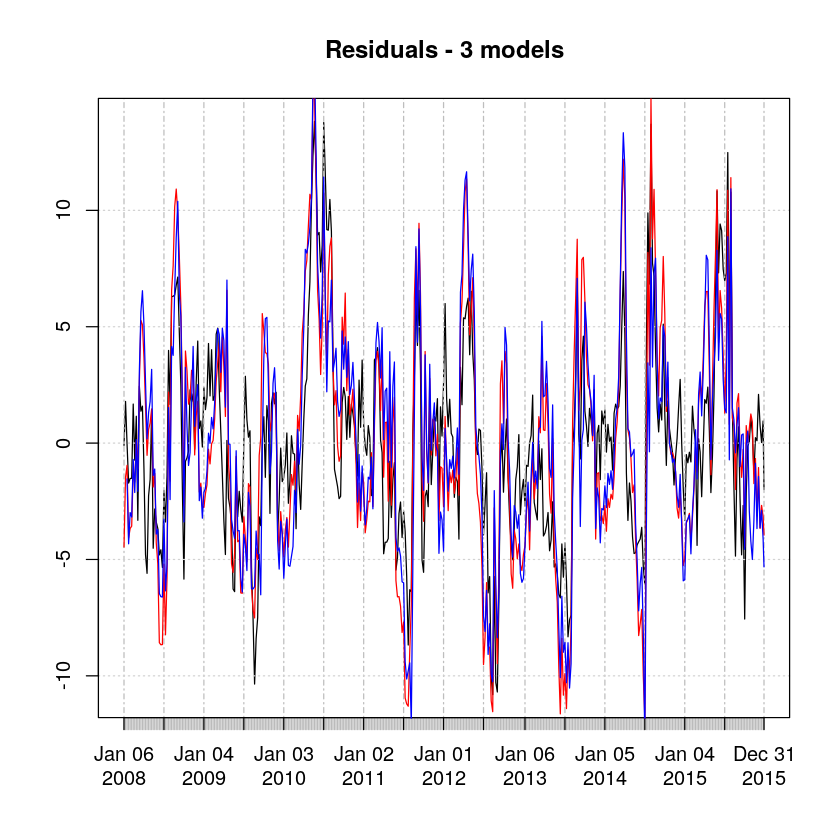

In [122]:
# Calculate the residuals for the models
gpp$resid_decompseas <- gpp$GPP_g_int - gpp$decomp_seas
gpp$resid_ta_lm <- gpp$GPP_g_int - gpp$fitted_ta_lm
gpp$resid_taP_lm <- gpp$GPP_g_int - gpp$fitted_taP_lm

# Plot residuals
p <- plot(gpp$resid_decompseas, main='Residuals - 3 models')
lines(gpp$resid_ta_lm, col='red')
lines(gpp$resid_taP_lm, col='blue')

printfigs(p, paste(site, '_ta_resid.svg', sep=''), 'figures/', 6, 3.5)

pdf 
  2

                    
April      3.7907843
August     1.8310837
December  -2.8642431
February  -1.3426168
January   -2.8087974
July      -3.5097833
June      -4.1314107
March      2.8143163
May        1.6850177
November  -0.2493552
October    1.9492147
September  2.6623333

             residual
2014-01-01 -2.8087974
2014-02-01 -1.3426168
2014-03-01  2.8143163
2014-04-01  3.7907843
2014-05-01  1.6850177
2014-06-01 -4.1314107
2014-07-01 -3.5097833
2014-08-01  1.8310837
2014-09-01  2.6623333
2014-10-01  1.9492147
2014-11-01 -0.2493552
2014-12-01 -2.8642431

Warning message:
: Stacking not well defined when ymin != 0

pdf 
  2

Warning message:
: Stacking not well defined when ymin != 0

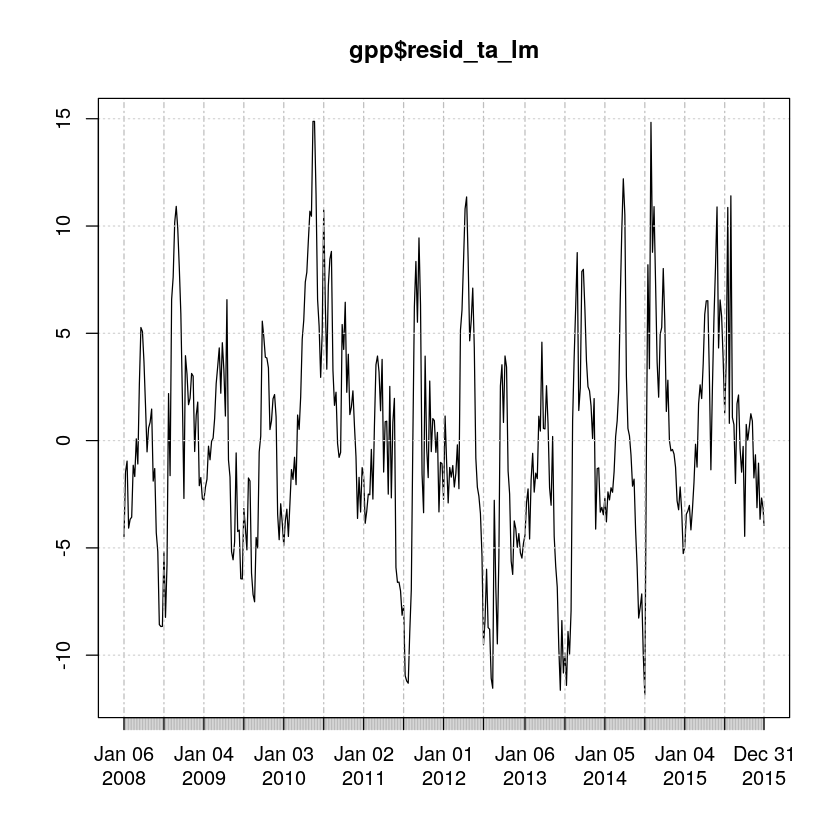

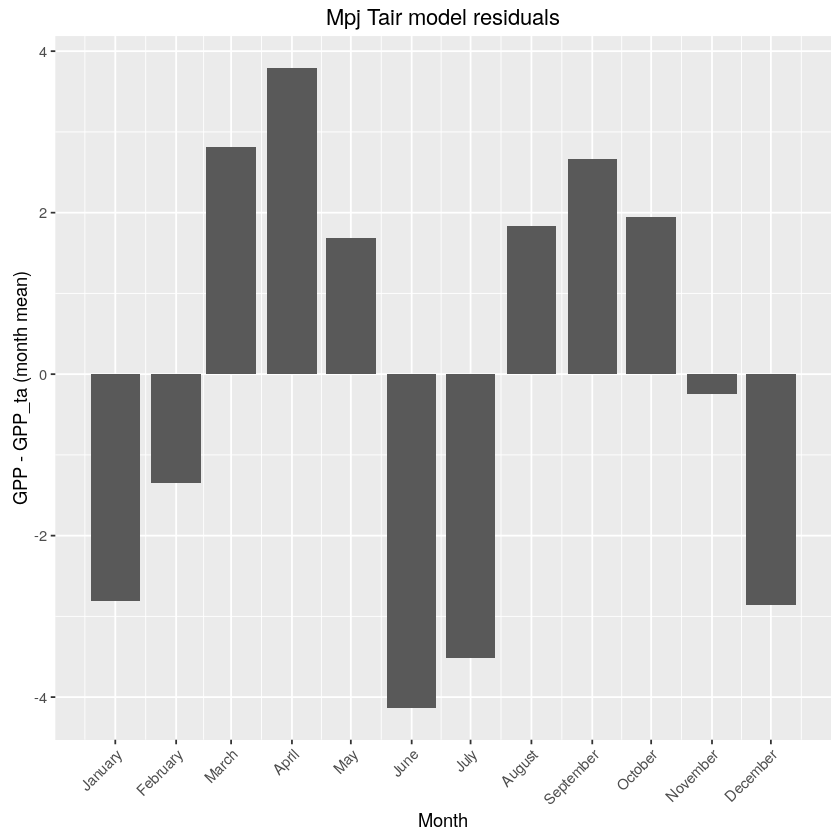

In [65]:

agg_mon <- aggregate(gpp$resid_ta_lm, months(index(gpp)), mean)
agg_mon
data <- coredata(agg_mon)
idx <- as.Date(paste('1', index(agg_mon), '2014', sep='-'), '%d-%b-%Y')
new <- as.xts(agg_mon, order.by=idx)
names(new) <- 'residual'
new
library('scales')
resid_monthly_plot <- ggplot(new) + geom_bar(aes(index(new), residual), stat='identity') + 
    xlab("Month") + ylab("GPP - GPP_ta (month mean)") +
    scale_x_date(date_breaks = "1 month", date_labels = "%B") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    ggtitle(paste(site, 'Tair model residuals', sep=' '))

printfigs(resid_monthly_plot, paste(site, '_resid_ta_lm_bars.svg', sep=''), 'figures/', 6, 3.5)
resid_monthly_plot